In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [24]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test) %>% (kaggle.house$na$fixAll)

df.training.raw <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    mutate(sale_price_log = log(SalePrice)) %>%
    select(-dataSource)
    
df.testing.raw  <- 
    df.combined %>% 
    filter(dataSource == "test") %>% 
    select(-dataSource, -SalePrice)

In [45]:
df.training.numeric <- 
    df.training.raw %>%
    select(-dplyr::one_of(kaggle.house$trans$type1TransContainer %>% names)) %>%
    select(-dplyr::one_of(kaggle.house$trans$type2TransContainer %>% names))

# Should be only numeric columns
df.training.numeric %>% purrr::map(function (col) { !is.numeric(col) }) %>% unlist %>% sum == 0

df.training.numeric %>% colnames %>% sort

[1] TRUE

[1] "BedroomAbvGr"   "BsmtFinSF1"     "BsmtFinSF2"     "BsmtFullBath"  
 [5] "BsmtHalfBath"   "BsmtUnfSF"      "EnclosedPorch"  "Fireplaces"    
 [9] "FullBath"       "GarageArea"     "GarageCars"     "GarageYrBlt"   
[13] "GrLivArea"      "HalfBath"       "KitchenAbvGr"   "LotArea"       
[17] "LotFrontage"    "LowQualFinSF"   "MasVnrArea"     "MiscVal"       
[21] "MoSold"         "OpenPorchSF"    "OverallCond"    "OverallQual"   
[25] "PoolArea"       "SalePrice"      "sale_price_log" "ScreenPorch"   
[29] "TotalBsmtSF"    "TotRmsAbvGrd"   "WoodDeckSF"     "X1stFlrSF"     
[33] "X2ndFlrSF"      "X3SsnPorch"     "YearBuilt"      "YearRemodAdd"  
[37] "YrSold"

In [47]:
df.training.numeric %>% group_by(BedroomAbvGr) %>% count

BedroomAbvGr,n
0,6
1,50
2,358
3,804
4,213
5,21
6,7
8,1


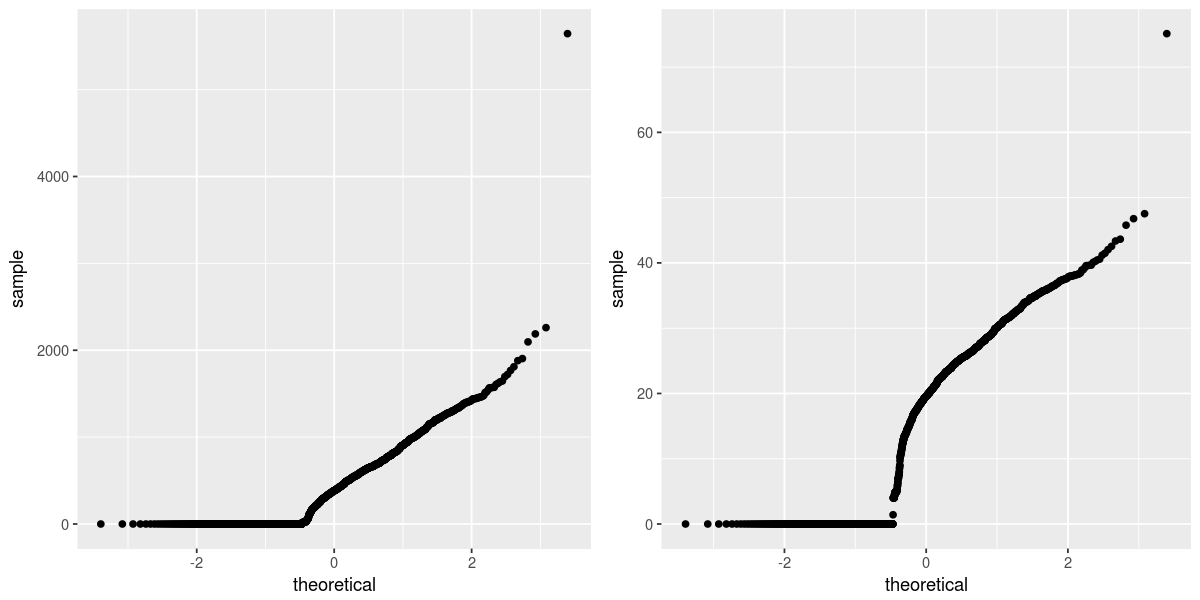

In [59]:
options(repr.plot.width = 10, repr.plot.height = 5)

df <- df.training #%>%  select(BsmtFinSF1) %>% filter(BsmtFinSF1 > 0)

p1 <- ggplot() +
      stat_qq(aes(sample=BsmtFinSF1), data=df)

p2 <- ggplot() +
      stat_qq(aes(sample=BsmtFinSF1), data=df %>% mutate(BsmtFinSF1=sqrt(BsmtFinSF1)))

grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))